In [3]:
# === Built-in ===
import os

# === Third-party ===
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import mahalanobis

# === PyTorch ===
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

Classe per Estrazione delle Feature - Task 1-2

In [4]:
class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None
        self.model.avgpool.register_forward_hook(self._hook_avgpool)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def _hook_avgpool(self, module, input, output):
        self.feature = output.squeeze().detach().numpy()

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _ = self.model(input_tensor)

        feat_2048 = self.feature
        return 0.5 * (feat_2048[::2] + feat_2048[1::2])  # Ridotto a 1024

Estrazione,Salvataggio e Caricamneto delle Feature 

In [5]:
def process_and_save_features(base_folder, subfolders, output_file):
    extractor = ResNetAvgPool1024Extractor()
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extractor.extract_feature(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


def load_features(file_path):
    data = np.load(file_path, allow_pickle=True)
    return data["features"], data["filenames"], data["labels"]

Visualizzazione dei Risultati

In [6]:
def plot_matches(query_path, indices, labels, filenames, distances, metric_label):
    k = len(indices)
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))

    # Immagine query
    axs[0].imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    # Immagini simili
    for i, idx in enumerate(indices):
        img_path = os.path.join("Part1", labels[idx], filenames[idx])
        match_img = cv2.imread(img_path)
        axs[i + 1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i+1}\n{metric_label}={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

Ricerca Immagini Simili - Euclidea / Coseno  -- Task 3

In questa funzione chiamiamo una solo distanza 

In [7]:
def find_k_similar(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    dist_euc = euclidean_distances(features, query_feature).flatten()
    dist_cos = cosine_distances(features, query_feature).flatten()

    top_k_idx_euc = np.argsort(dist_euc)[:k]
    top_k_idx_cos = np.argsort(dist_cos)[:k]

    print(f"\nTop {k} simili a {img_path}:")
    print("=== Euclide ===")
    for rank, idx in enumerate(top_k_idx_euc):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Euclid: {dist_euc[idx]:.4f}")

    print("=== Coseno ===")
    for rank, idx in enumerate(top_k_idx_cos):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Cosine: {dist_cos[idx]:.4f}")

    # Visualizza entrambi
    plot_matches(img_path, top_k_idx_euc, labels, filenames, dist_euc, "Euclid")
    plot_matches(img_path, top_k_idx_cos, labels, filenames, dist_cos, "Cosine")

Ricerca Immagini Simili - Mahalanobis -- Task 3

In [8]:
def find_k_similar_mahalanobis(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)
    cov = np.cov(features.T)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Covarianza non invertibile. Uso pseudoinversa.")
        cov_inv = np.linalg.pinv(cov)

    distances = np.array([mahalanobis(query_feature, f, cov_inv) for f in features])
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} simili (Mahalanobis) a {img_path}:")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {distances[idx]:.2f}")

    plot_matches(img_path, top_k_idx, labels, filenames, distances, "M")

Esecuzione

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt1.npz
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt2.npz
[FINE] Totale immagini processate: 3006

Top 5 simili a Part1/brain_glioma/brain_glioma_0005.jpg:
=== Euclide ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Euclid: 0.0000
2. brain_glioma_0071.jpg | Classe: brain_glioma | Euclid: 2.1480
3. brain_glioma_0258.jpg | Classe: brain_glioma | Euclid: 2.2868
4. brain_glioma_0311.jpg | Classe: brain_glioma | Euclid: 2.4746
5. brain_glioma_0717.jpg | Classe: brain_glioma | Euclid: 3.2342
=== Coseno ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Cosine: 0.0000
2. brain_glioma_0071.jpg | Classe: brain_glioma | Cosine: 0.0366
3. brain_glioma_0258.jpg | Classe: brain_glioma | Cosi

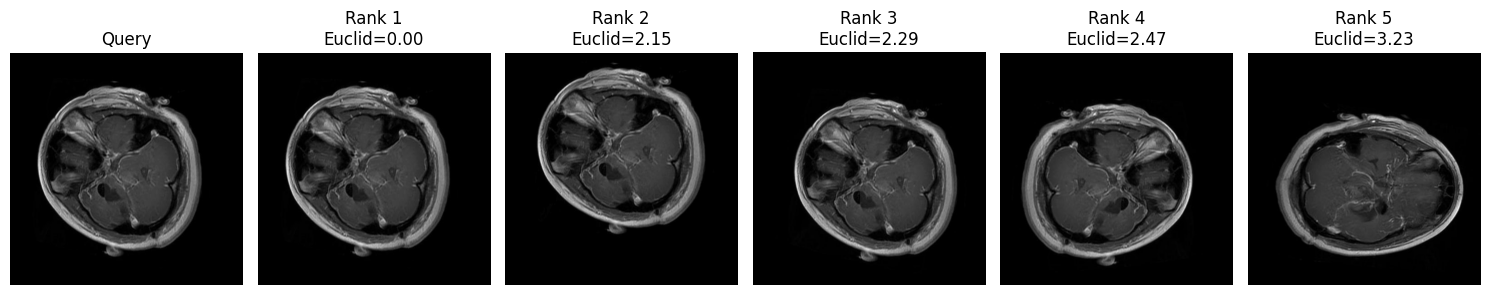

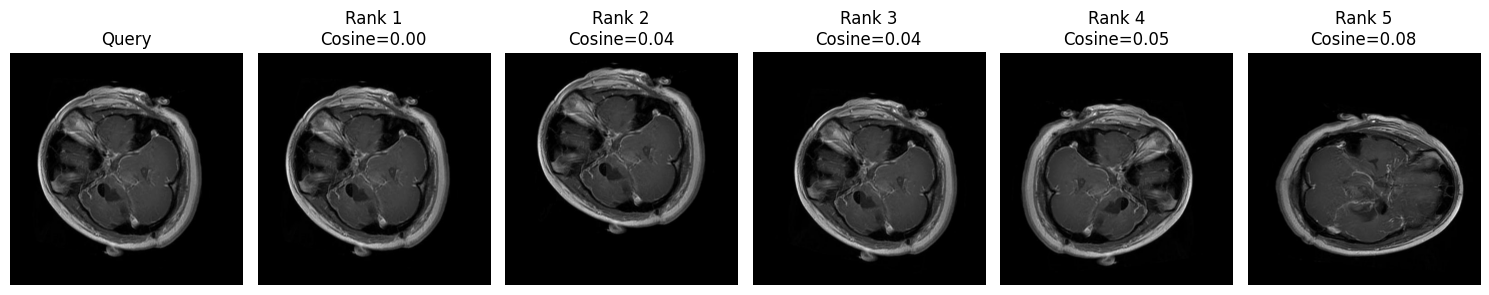


Top 5 simili (Mahalanobis) a Part1/brain_glioma/brain_glioma_0005.jpg:
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 30.94
3. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 31.58
4. brain_glioma_0311.jpg | Classe: brain_glioma | Distanza: 33.31
5. brain_menin_0578.jpg | Classe: brain_menin | Distanza: 34.19


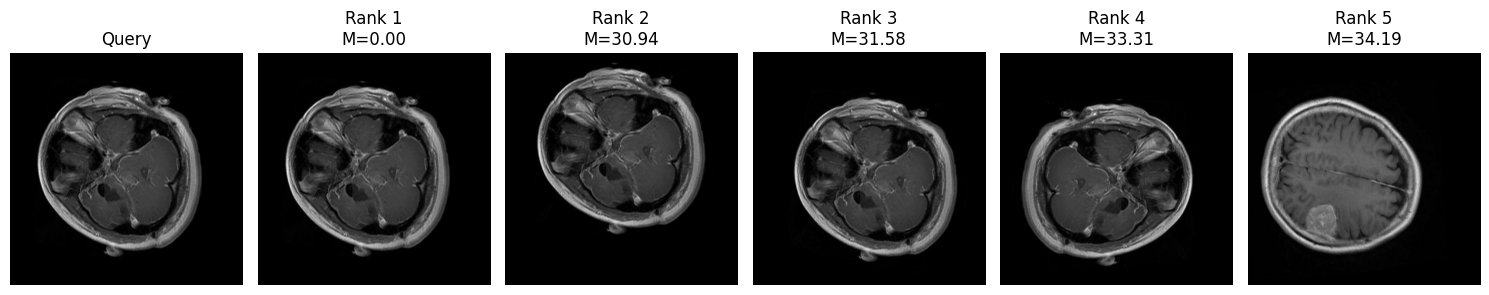

In [9]:
# === Parametri ===
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]



# === Estrai e salva features (solo una volta) ===
process_and_save_features("Part1", subfolders, "resnet1024_pt1.npz")
process_and_save_features("Part2", subfolders, "resnet1024_pt2.npz")

# === Carica features ===
features_pt1, filenames_pt1, labels_pt1 = load_features("resnet1024_pt1.npz")
features_pt2, filenames_pt2, labels_pt2 = load_features("resnet1024_pt2.npz")

# === Inizializza extractor ===
extractor = ResNetAvgPool1024Extractor()

# === Query ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)
find_k_similar_mahalanobis(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)

Task 4:

In [10]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def compute_metric(query_feat, target_feats, metric="euclidean"):
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return euclidean_distances(target_feats, query_feat).flatten()
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats).flatten()
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        dists_or_sims = compute_metric(query_feat, class_feats, metric)
        score = dists_or_sims.mean()
        scores.append(score)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

def predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    class_prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        class_prototypes.append(class_feats.mean(axis=0))
    class_prototypes = np.vstack(class_prototypes)

    scores = compute_metric(query_feat, class_prototypes, metric)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

def task4_predict_labels_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")
    predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric)
    predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric)


In [11]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="euclidean")
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="cosine")


======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: euclidean]
Classe: brain_tumor | Score medio: 5.6695
Classe: brain_menin | Score medio: 6.2810

[STRATEGIA: prototipo di classe - metrica: euclidean]
Classe: brain_tumor | Score: 3.9200
Classe: brain_menin | Score: 4.5812

======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: cosine]
Classe: brain_tumor | Score medio: 0.7407
Classe: brain_menin | Score medio: 0.6695

[STRATEGIA: prototipo di classe - metrica: cosine]
Classe: brain_tumor | Score: 0.8632
Classe: brain_menin | Score: 0.8077


Task 5:

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

def task5_latent_semantics_resnet1024(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet AvgPool1024
    usando SVD, LDA o KMeans. Salva i risultati su file e visualizza lo spazio latente.
    """
    # === Carica feature ===
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data["features"]
    filenames = data["filenames"]
    labels = data["labels"]

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione 2D ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # === Salvataggio output ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa per KMeans

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

In [13]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

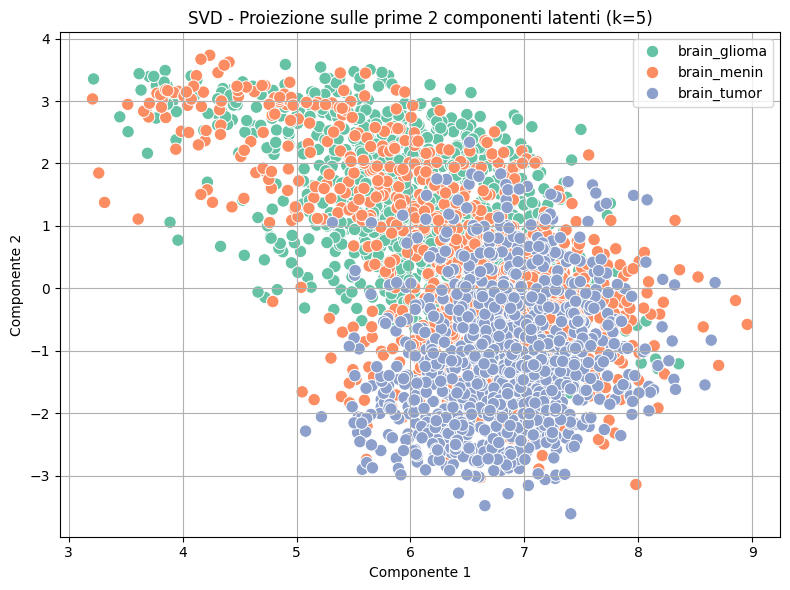

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnet1024_k5.txt


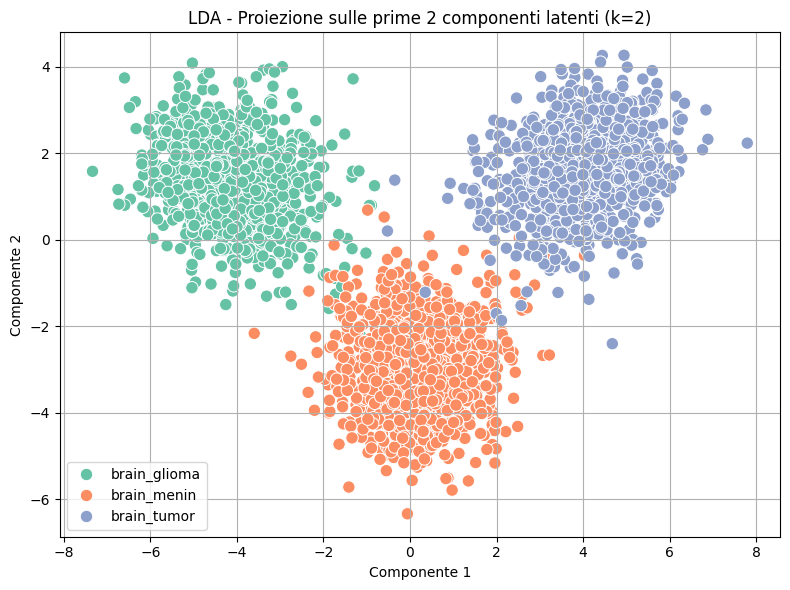

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnet1024_k2.txt


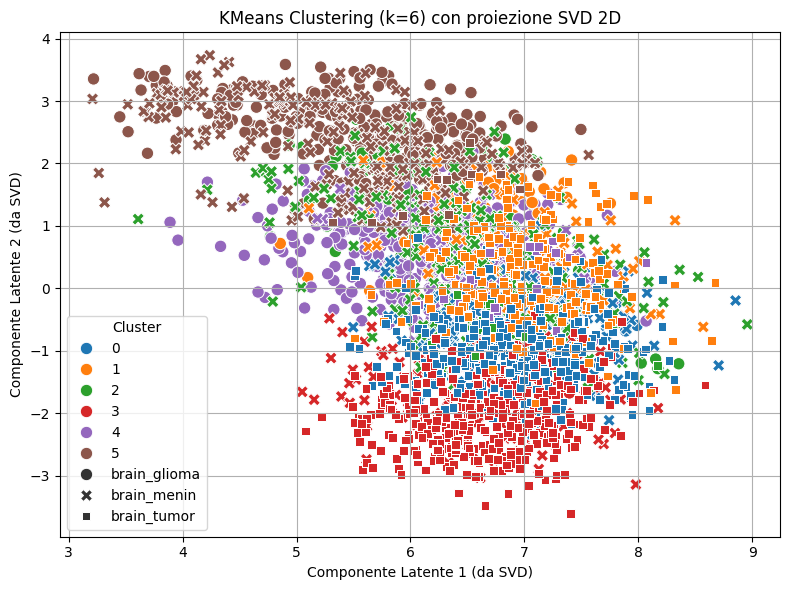

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnet1024_k6.txt


In [14]:
# === ESEMPIO USO ===
task5_latent_semantics_resnet1024("resnet1024.npz", technique="svd", k=5)
task5_latent_semantics_resnet1024("resnet1024.npz", technique="lda", k=2)
task5_latent_semantics_resnet1024("resnet1024.npz", technique="kmeans", k=6)

Task 6:

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA su ResNet1024)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative


def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values



Task 6a – Dimensionalità intrinseca (globale):

[INFO] Feature matrix shape: (3006, 1024)
[INFO] k ottimale suggerito (soglia 90%): 186
Soglia 90% : k = 186
[INFO] k ottimale suggerito (soglia 95%): 320
Soglia 95% : k = 320
[INFO] k ottimale suggerito (soglia 99%): 627
Soglia 99% : k = 627


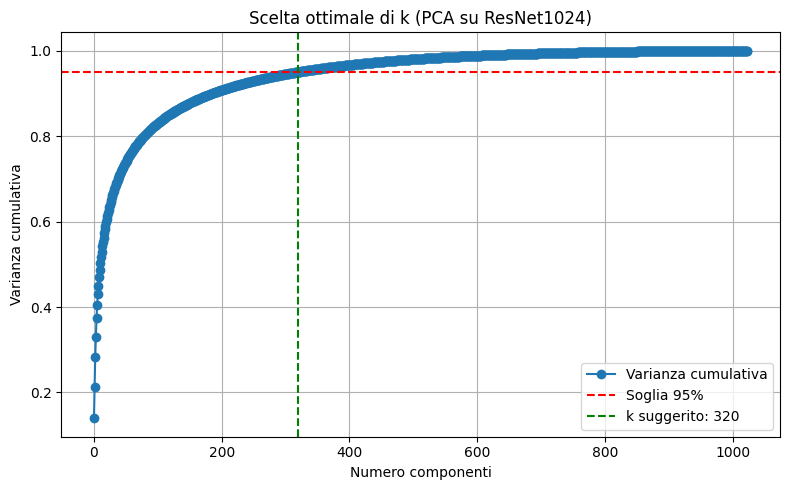

[INFO] k ottimale suggerito (soglia 95%): 320


(np.int64(320),
 array([0.13935132, 0.21309862, 0.28317013, ..., 0.99999714, 0.9999983 ,
        0.9999991 ], shape=(1024,), dtype=float32))

In [16]:
print("\nTask 6a – Dimensionalità intrinseca (globale):\n")
k_suggeriti_resnet1024 = suggest_k(features_pt1)
estimate_intrinsic_dimensionality(features_pt1, threshold=0.95, plot=True)


In [17]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}
    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(np.array(labels) == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" • Label '{label}' : k = {k}")
    return label_dim_map


In [18]:
print("\nTask 6b – Dimensionalità intrinseca per etichetta (ResNet1024):\n")
label_dimensionalities_resnet1024 = estimate_dimensionality_per_label(
    features_pt1, labels_pt1, threshold=0.95
)



Task 6b – Dimensionalità intrinseca per etichetta (ResNet1024):

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 220
 • Label 'brain_glioma' : k = 220
[INFO] k ottimale suggerito (soglia 95%): 247
 • Label 'brain_menin' : k = 247
[INFO] k ottimale suggerito (soglia 95%): 270
 • Label 'brain_tumor' : k = 270


Task 7:

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import numpy as np

def compute_latent_semantics_per_class_resnet(X, y, k=10):
    class_models = {}
    class_means = {}
    labels = np.unique(y)

    for label in labels:
        X_class = X[np.array(y) == label]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)

        svd = TruncatedSVD(n_components=k, random_state=42)
        latent = svd.fit_transform(X_scaled)

        class_models[label] = {
            'scaler': scaler,
            'svd': svd,
            'latent_vectors': latent
        }
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_labels_with_latent_semantics(X_test, class_models, class_means):
    predictions = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))
            x_latent = model['svd'].transform(x_scaled)
            dist = np.linalg.norm(x_latent - class_means[label])
            if dist < min_dist:
                min_dist = dist
                best_label = label
        predictions.append(best_label)
    return predictions

def evaluate_predictions(y_true, y_pred):
    print("[VALUTAZIONE] Metriche per classe:")
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)
    for label, p, r, f in zip(np.unique(y_true), precision, recall, f1):
        print(f"Classe {label}: Precisione={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")
    print(f"\nAccuratezza globale: {accuracy:.2f}\n")
    print(classification_report(y_true, y_pred))

In [25]:
# ====== ESECUZIONE ======

# Step 1: addestramento sulle immagini Part1
class_models_resnet1024, class_means_resnet1024 = compute_latent_semantics_per_class_resnet(
    features_pt1, labels_pt1, k=10
)

# Step 2: predizione sulle immagini Part2
predicted_labels_resnet1024 = predict_labels_with_latent_semantics(
    features_pt2, class_models_resnet1024, class_means_resnet1024
)

# Step 3: valutazione delle predizioni
evaluate_predictions(labels_pt2, predicted_labels_resnet1024)

[VALUTAZIONE] Metriche per classe:
Classe brain_glioma: Precisione=0.68, Recall=0.57, F1-Score=0.62
Classe brain_menin: Precisione=0.46, Recall=0.51, F1-Score=0.48
Classe brain_tumor: Precisione=0.46, Recall=0.49, F1-Score=0.48

Accuratezza globale: 0.52

              precision    recall  f1-score   support

brain_glioma       0.68      0.57      0.62      1002
 brain_menin       0.46      0.51      0.48      1002
 brain_tumor       0.46      0.49      0.48      1002

    accuracy                           0.52      3006
   macro avg       0.53      0.52      0.53      3006
weighted avg       0.53      0.52      0.53      3006



task 9

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))
